In [1]:
from load_imgs_from_folder import *

In [2]:
stitched_imgs_names, stitched_imgs = load_images_from_folder(r'tiled_data', ['Stitched'], '*.tif')

In [3]:
from make_images_one_size import *

In [4]:
stitched_imgs = make_imgs_one_size(stitched_imgs)

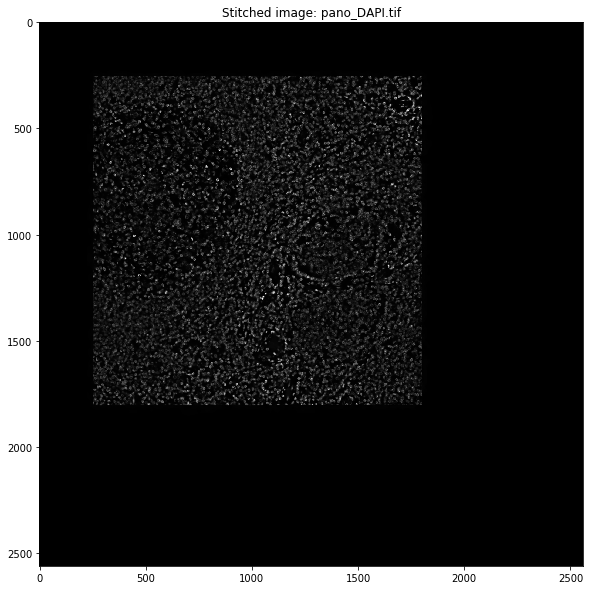

In [6]:
# Отображение одного изображения для проверки
%matplotlib inline
from matplotlib import pyplot as plt

idx = 3
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(stitched_imgs[idx], cmap='gray')
ax.set_title("Stitched image: " + stitched_imgs_names[idx])
plt.show()

# Обрезка области с клетками
Для этого будем использовать bounding box отсегментированного простым методом суммарного изображения всех каналов

https://blog.kitware.com/histogram-based-thresholding/

In [7]:
I_sum = sum(stitched_imgs)

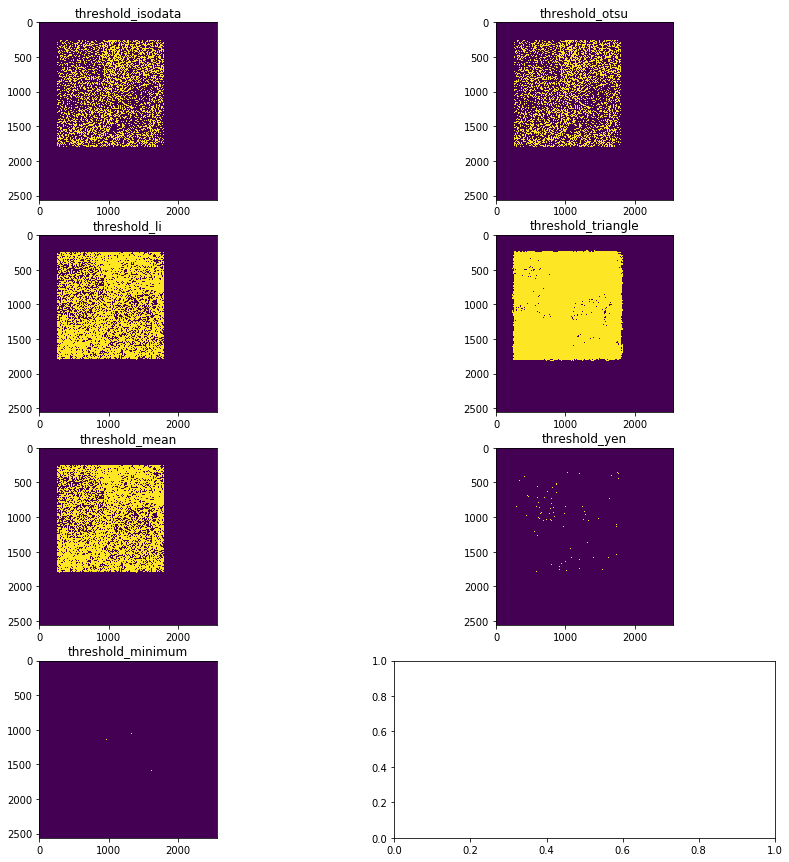

In [37]:
from skimage.filters import *
fig, axes = plt.subplots(4, 2, figsize=(15,15))
# threshold_local threshold_niblack threshold_sauvola - являются локальными методами и
# приводят к появлению артефактов на границах
for idx, thresh_name in enumerate([threshold_isodata, threshold_li, threshold_mean, \
                   threshold_minimum, threshold_otsu, \
                    threshold_triangle, threshold_yen]):
    thresh = thresh_name(I_sum)
    BW = I_sum > thresh
    axes[idx % 4, idx // 4].imshow(BW)
    axes[idx % 4, idx // 4].set_title(thresh_name.__name__)
plt.show()

In [46]:
# Видим, что Triangle выполняет почти однородную заливку области изображения, его и будем дальше использовать, однако для него 
thresh = threshold_triangle(I_sum)
BW = I_sum > thresh

In [47]:
# Воспользуемся bounding box для определения ROI
import skimage
labeles, num = skimage.measure.label(BW, background=0, connectivity=1, return_num=True)
props = skimage.measure.regionprops(labeles)

# Опреление bounding box для всех найденных объектов
bboxs = np.array([props[i].bbox for i in range(num-1)])
# Определение наибольшего bounding box, охватывающего все объекты
bbox = [min(bboxs[:, 0]), min(bboxs[:, 1]), max(bboxs[:, 2]), max(bboxs[:, 3])]
print(bbox)

[233, 225, 1835, 1833]


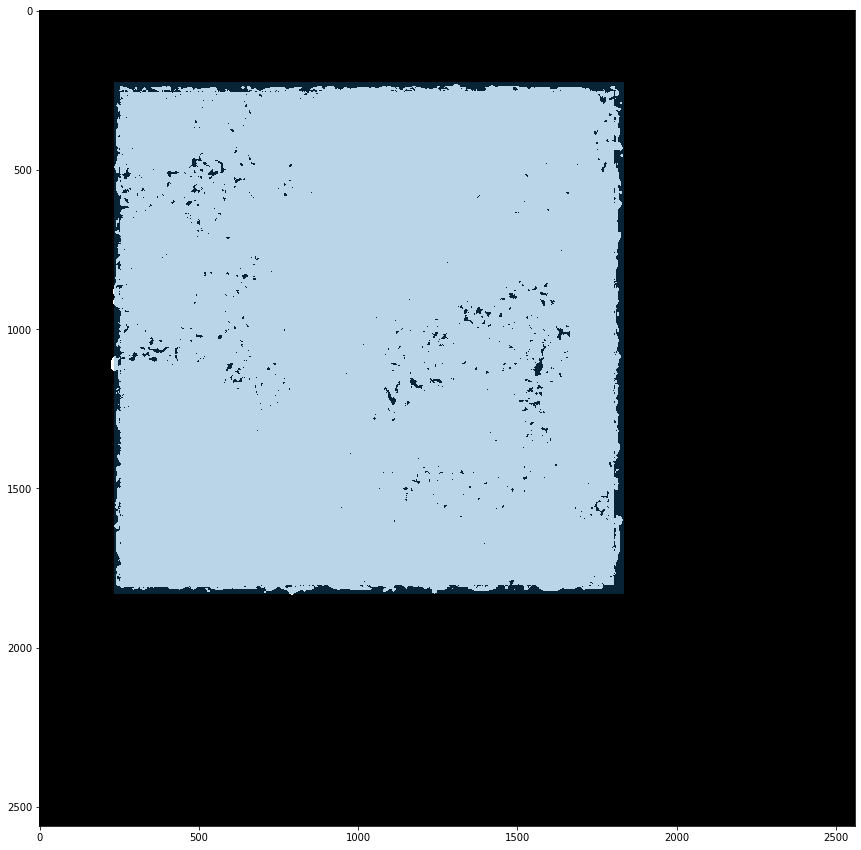

In [48]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(BW, cmap='gray')
bbox_rec = Rectangle((bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], alpha=0.3)
ax.add_patch(bbox_rec)
plt.show()

Несмотря на однородность заливки, на границах данная бинаризация дает неадекватный результат ввиду ее имплементации, поэтому будем использовать порог по Отсу

In [49]:
thresh = threshold_otsu(I_sum)
BW = I_sum > thresh

In [50]:
# Воспользуемся bounding box для определения ROI
import skimage
labeles, num = skimage.measure.label(BW, background=0, connectivity=1, return_num=True)
props = skimage.measure.regionprops(labeles)

# Опреление bounding box для всех найденных объектов
bboxs = np.array([props[i].bbox for i in range(num-1)])
# Определение наибольшего bounding box, охватывающего все объекты
bbox = [min(bboxs[:, 0]), min(bboxs[:, 1]), max(bboxs[:, 2]), max(bboxs[:, 3])]
print(bbox)

[256, 256, 1804, 1804]


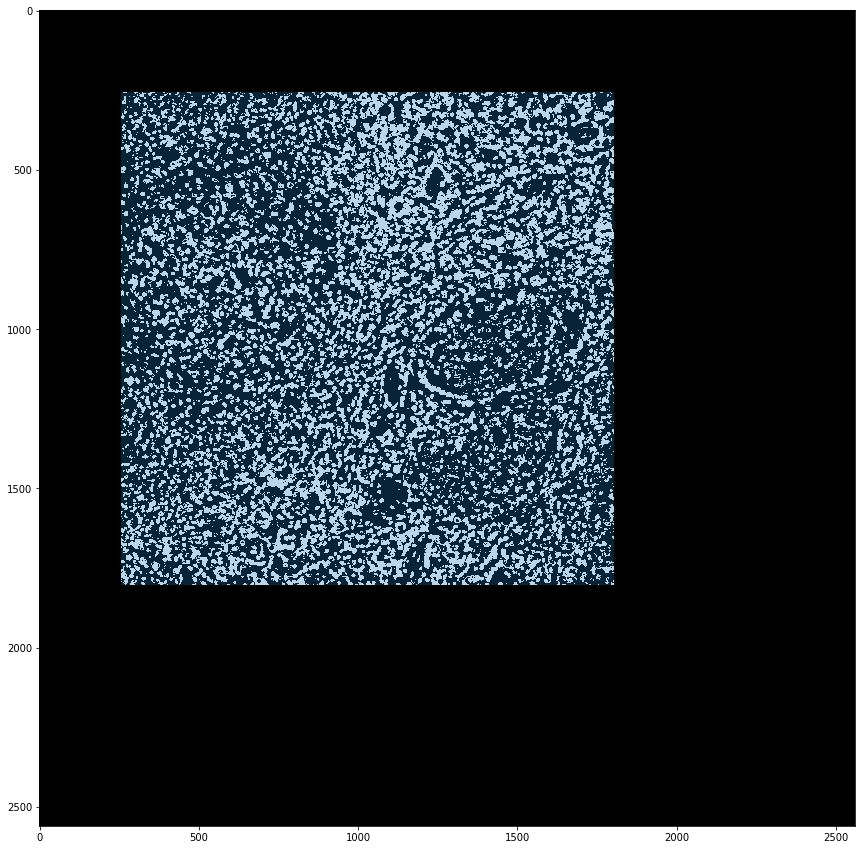

In [51]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(BW, cmap='gray')
bbox_rec = Rectangle((bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], alpha=0.3)
ax.add_patch(bbox_rec)
plt.show()

In [52]:
def make_dir(dir_abs_path):
    try:
        os.mkdir(dir_abs_path)
    except OSError as error:
        pass
    
# Применение обрезки ко всем панорамным изображениям
for i in range(len(stitched_imgs)):
    stitched_imgs[i] = stitched_imgs[i][bbox[0]:bbox[2], bbox[1]:bbox[3]]
    cur_path = os.path.join(r'tiled_data', 'Stitched_cropped')
    make_dir(cur_path)
    cv2.imwrite(os.path.join(cur_path, stitched_imgs_names[i]), stitched_imgs[i])